In [46]:
%matplotlib inline
import os
import random
import itertools
import numpy as np
import pandas as pd

from IPython import display

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})

In [151]:
nlayers = 9


layer_index = range(1, nlayers + 1)

column_model = pd.Series(np.random.random(nlayers), index = layer_index)


#McICA

In [156]:
# mcica

def get_mcica_column_modified_drawn(model = None, drawn = None):
    modified = pd.Series(np.zeros(model.shape), index = model.index)
    modified[1] = drawn[1].copy()
    for l in model.index[1 :]:
        clearskyabove_model = 1 - model[l - 1]
        cloudskyabove_drawn = drawn[l - 1]
        
        if cloudskyabove_drawn > clearskyabove_model:
            modified[l] = cloudskyabove_drawn
        else:
            modified[l] = drawn[l] * clearskyabove_model
    modified.index = model.index
    return modified



def get_mcica_column_sub(model = None, modified = None):
    sub = pd.Series(np.ones(model.shape), index = model.index)
    return sub.where(modified > model, other = 0)



def get_mcica_columns_history(model = None, drawn = None, 
                              modified = None, sub = None):
    columns_list = [('model', model),
                    ('model clearsky', 1 - model),
                    ('drawn', drawn),
                    ('drawn modified', modified),
                    ('sub column', sub)]

    history = pd.DataFrame.from_items(columns_list)
    return history



def plot_fracs(history = None):
    names_cloudsky = ('model', 'drawn', 'drawn modified', 'sub column')
    
    fig, axs = plt.subplots(figsize = (len(names_cloudsky) * 3, 7), 
                            nrows = 1, ncols = len(names_cloudsky),
                            sharey = True)
    
    for ax, name in zip(axs, names_cloudsky):
        color = 'k' if name == 'sub column' else 'b'
        history[name].plot(ax = ax, kind = 'barh', width = .95, alpha = .3, color = color)
        
        ax.invert_yaxis()
        
        ax.set_xlim((0, 1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 10.)
        
        ax.set_title(name)
        
    plt.figtext(x = .07, y = .5, s = 'layer index', rotation = 90.)
    plt.figtext(x = .5, y = .05, s = 'cloud fraction', fontsize = 15)



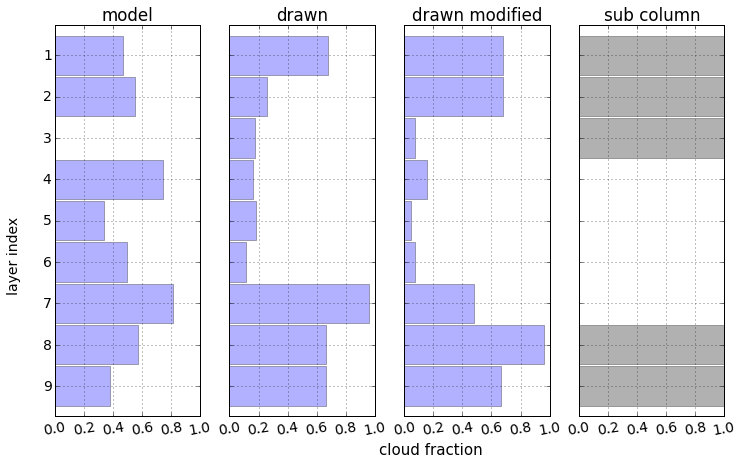

In [157]:
column_drawn = pd.Series(np.random.random(nlayers), index = layer_index)

column_modified = get_mcica_column_modified_drawn(model = column_model, drawn = column_drawn)

column_sub = get_mcica_column_sub(model = column_model, modified = column_modified)

columns_history = get_mcica_columns_history(model = column_model, 
                                            drawn = column_drawn,
                                            modified = column_modified,
                                            sub = column_sub)

plot_fracs(history = columns_history)

1. A column of random cloud fractions is drawn from a random number generator.
2. This column is modified with respect to the model cloud fractions according to the following rules:
    * If the random cloud fraction in the layer above is larger than the model clear sky in the layer above, then the random cloud fraction in the current layer is changed to be equal to the random cloud fraction in the layer above.  The current layer and the layer above are said to be *maximally overlapped*.
    * If the random cloud fraction in the layer above is smaller than the model clear sky in the layer above, then the random cloud fraction in the current layer is changed to be equal to the random cloud fraction in the current layer, multiplied by the model clear sky in the layer above.  The current layer and the layer above are said to be *randomly overlapped*.
    * The random cloud fraction of the highest layer remains unchanged.
3. For example, for layer 8, because the random cloud fraction in layer 7 is larger than the model clear sky in layer 7, the random cloud fraction of layer 8 is changed to be the random cloud fraction in layer 7.
4. On the other hand, for layer 4, because the random cloud fraction in layer 3 is smaller than the model clear sky in layer 3, the random cloud fraction of layer 4 is changed to be equal the current random cloud fraction times the model clear sky above.  In this case, this is equal to 1, so the current random cloud fraction actually remains unchanged. 
5. After the column of random cloud fraction has been modified in this way, it is again compared with the model cloud fractions to produce a column in which each layer is said to be fully cloudy or cloudless.  It is fully cloudy if the random cloud fraction in the modified column is greater than the model's, cloudless if it is less.  The resulting column is referred to as a sub-column.  
6. Radiative trasnfer can now be applied to this column to compute fluxes, because we now have a situation where we can associate a single value of optical depth with an entire layer.  When it is cloudless, this value is zero.
7. When using this cloud-overlap scheme, many random columns are drawn to produce many sub-columns: one for each g-points in the k-distribution.

# MaxRand

In [158]:
# MaxRand

def maxrand_maxcovers(model = None):
    nlayers_sec = int(len(model.index) / 3)
    maxcover_top = model.iloc[: nlayers_sec].max()
    maxcover_mid = model.iloc[nlayers_sec: 2 * nlayers_sec].max()
    maxcover_bot = model.iloc[2 * nlayers_sec: ].max()
    return pd.Series([maxcover_top, maxcover_mid, maxcover_bot], 
                     index = ['top', 'middle', 'bottom'])


def maxrand_maxcol(model = None):
    nlayers_sec = int(len(model.index) / 3)
    maxcovers = maxrand_maxcovers(model = model)
    maxcol = pd.Series(np.zeros(model.shape), index = model.index)
    maxcol.iloc[: nlayers_sec] = maxcovers['top']
    maxcol.iloc[nlayers_sec: 2 * nlayers_sec] = maxcovers['middle']
    maxcol.iloc[2 * nlayers_sec:] = maxcovers['bottom']
    return maxcol


def maxrand_subcol(nlayers = 9, top_cloudy = 0, mid_cloudy = 0, bot_cloudy = 0):
    subcol = pd.Series(np.zeros(nlayers), index = range(1, nlayers + 1))
    nlayer_sec = int(nlayers / 3)
    subcol.iloc[: nlayer_sec] = 1 if top_cloudy else 0
    subcol.iloc[nlayer_sec: 2 * nlayer_sec] = 1 if mid_cloudy else 0
    subcol.iloc[2 * nlayer_sec: ] = 1 if bot_cloudy else 0
    return subcol


def maxrand_subcol_prob(model = None, top_cloudy = 0, mid_cloudy = 0, bot_cloudy = 0):
    cloudy = maxrand_maxcovers(model)
    clearsky = 1 - cloudy
    df = pd.DataFrame({1: cloudy, 0: clearsky})
    probability = df.loc['top', top_cloudy] * \
    df.loc['middle', mid_cloudy] * \
    df.loc['bottom', bot_cloudy]
    return probability


def maxrand_plot_subcol_prob(model = None):
    subcol_cloudys = itertools.product([1, 0], repeat = 3)
    d_subcol_cloudys = [dict(zip(['top_cloudy', 'mid_cloudy', 'bot_cloudy'],
                               subcol_cloudy)) for subcol_cloudy in subcol_cloudys] 
    
    nlayers = len(model.index)
    
    fig, axs = plt.subplots(figsize = (3 * 8, 6),
                           nrows = 1, ncols = 8,
                           sharey = True)
    
    for ax, d in zip(axs, d_subcol_cloudys):
        subcol = maxrand_subcol(nlayers = nlayers, **d)
        prob_subcol = maxrand_subcol_prob(model=model, **d)
        subcol.plot(ax = ax, kind = 'barh', alpha = .3, color = 'k', width = .9)
        ax.set_title('prob = {:.2f}'.format(prob_subcol))
        ax.set_xlim((0, 1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 10)
        
        ax.invert_yaxis()
    
    plt.figtext(x = .5, y = .98, s = 'MaxRand sub-columns', fontsize = 15)
    plt.figtext(x = 0.1, y = .5, s = 'layer index', rotation = 90.)    
    plt.figtext(x = .5, y = .05, s = 'cloud fraction')
    return fig


def maxrand_plot_maxcol(model = None):
    maxcol = maxrand_maxcol(model = model)
    fig, axs = plt.subplots(figsize = (3 * 2, 6),
                           ncols = 2, nrows = 1,
                           sharey = True)
    for ax, col , name in zip(axs, [model, maxcol], ['model', 'max overlapped']):
        col.plot(ax = ax, kind = 'barh', width = .9, alpha = .3, color = 'b')
        ax.set_xlim((0, 1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 10)
        
        ax.set_title(name)
        ax.invert_yaxis()
    
    plt.figtext(x = 0.05, y = .5, s = 'layer index', rotation = 90.)
    plt.figtext(x = .5, y = .05, s = 'cloud fraction')
    return fig

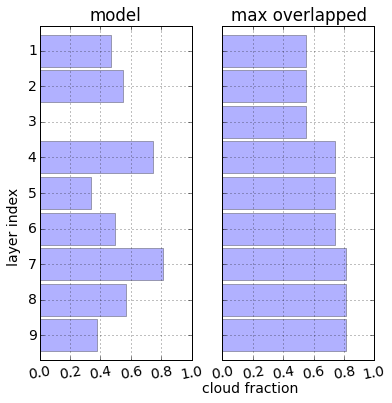

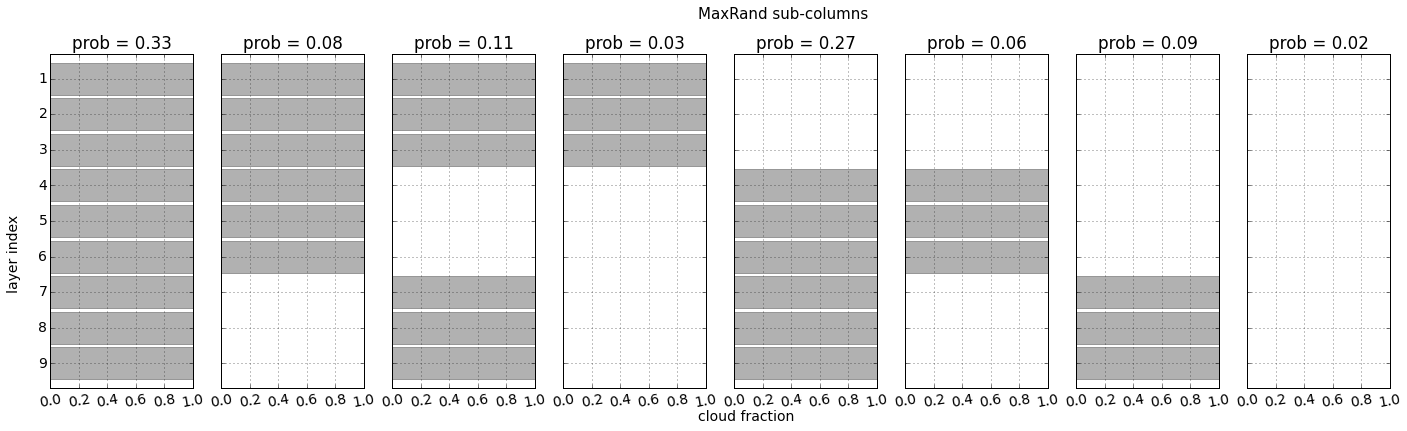

In [159]:
fig = maxrand_plot_maxcol(model = column_model)
fig = maxrand_plot_subcol_prob(model = column_model)

1. The atmosphere is split into 3 sections: top, middle and bottom. Here, each section has three layers.
2. Within each of these three sections, the clouds are maximally overlapped.
3. So, the smaller clouds are stretched to the size of the largest in each section. (see right panel of top figure)
4. There are now at most three different cloud fractions for the atmosphere.
5. These three cloud fractions are assumed to be randomly overlapped.  (Note this is not depicted in the right panel of the top figure, the clouds are left-aligned simply to compare their sizes.)
6. The random overlapping is implemented by interpreting cloud fraction as the probability of layer/section being cloudy, and one-minus-cloud fraction as the probability of it being clear.
7. So in the max-overlapped column, there is an about .8 chance that the bottom section of the atmosphere is cloudy because the cloud fraction of this section is .8, and there is .2 chance that it is clear.
8. Since each section can be either cloudy or clear, and there are 3 sections, there is a total of 8 combinations of cloudiness over the 3 sections.
9. The bottom figure shows these combinations.  The first one is when all 3 sections are cloudy, and the last one is when all 3 sections are clear.
10. The probability for each combination is the product of the probabilities of it being cloudy or clear in the three sections.  
11. For example, for the fourth combination, the probability of the bottom section being clear is .2, the probability of the middle section being clear is about .3 and the probability of the top section being cloudly is .5.  Multiplying the three together gives 0.03.
12. These combinations are similar to McICA's sub-columns in that radiative transfer can be applied to them to compute fluxes.   
13. When applying this cloud-overlapping scheme, flux is computed for all the combinations and an average is obtained using their probabilities.  
14. This is done at all g-points.


https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/

In [47]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')